# 1. Business Problem

## 1.1 Problem Statement
A cryptocurrency investment firm has hired us to predict the near future price of Bitcoin.
* They currently have data for select bitcoin exchanges, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price.
* The data was collected for the time period of Jan 2012 to March 2018
* Our task is to build a price prediction model using this data.
* If we can build a model to predict future prices with an average error of under US Dollars 100, then our client will be very satisfied with the our resultant model.

## 1.2 Business Objectives and Constraints
* Deliverable: Trained model file
* Win condition: Avg. prediction error < \$100
* Model Interpretability will be useful
* No latency requirement

# 2. Machine Learning Problem
## 2.1 Data Overview

For this project:
* The dataset has 3273377 observations with minute by minute updates from Jan 2012 to March 2018.
* Refer this link to download the dataset:
https://www.kaggle.com/mczielinski/bitcoin-historical-data

#### Target Variable
* 'pred_weight' - Weight of BTC

#### Features of the data:

* Open - Opening price of BTC.
* High - Highest price of BTC during that time period.
* Close - Closing price of BTC.
* Low - Lowest price of BTC during that time period.
* Volume_(BTC): Amount of Bitcoin traded during that time period in BTC value.
* Volume_(USD): Amount of Bitcoin traded during that time period in US Dollars.
* Weighted_Price: Value of 1 Bitcoin in US Dollars.

## 2.2 Mapping business problem to ML problem
### 2.2.1 Type of Machine Learning Problem
It is a regression problem, where given the above set of features, we need to predict the weighted price of BTC after 10 mins.

### 2.2.2 Performance Metric (KPI)
**Since it is a regression problem, we will use the following regression metrics:**
#### 2.2.2.1 Root Mean Squared Error (RMSE)

![title](Images/rmse.gif)

#### 2.2.2.2 R-squared
![title](Images/r_squared.png)

Just remember the value of R suared must be at least greater than 0 and 1 in the best case

#### 2.2.2.3 Mean Absolute Error (MAE):
![title](Images/mae.png)

* Remember, our win-condition for this project is predicting within \$100 of true transaction prices, on average.
* Mean absolute error (or MAE) is the average absolute difference between predicted and actual values for our target variable. That exactly aligns with the terms of our win condition!
* So we're aiming to get MAE below 100

## 2.3 Train-Test Splits
**80-20**

# 3. Exploratory Data Analysis

#### Import the libraries

In [3]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# import color maps
from matplotlib.colors import ListedColormap

# Seaborn for easier visualization
import seaborn as sns

from math import sqrt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Import classes for ML Models
from sklearn.linear_model import Ridge  ## Linear Regression + L2 regularization
from sklearn.svm import SVR ## Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor #Random Forest
from sklearn.neighbors import KNeighborsRegressor #KNN Regressor
from sklearn import linear_model   #Lasso Regressor
from sklearn.tree import DecisionTreeRegressor #Decision Tree Regressor
from sklearn.model_selection import cross_val_score  #Cross - validation 


# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

# To save the final model on disk
from sklearn.externals import joblib  ## Reference http://scikit-learn.org/stable/modules/model_persistence.html

## 3.1 Load real estate data from CSV

In [24]:
df = pd.read_csv('bitcoin_data.csv')

In [25]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [26]:
df.isnull().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [27]:
df.shape

(3273377, 8)

## 3.2 Converting Timestamp to Date

In [28]:
df['Date'] = pd.to_datetime(df.Timestamp, unit = 's')

In [33]:
df = df.set_index('Date')

In [34]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,,
2011-12-31 07:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [35]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06
mean,1.423719e+09,1.282265e+03,1.283527e+03,1.280822e+03,1.282248e+03,1.116149e+01,1.356582e+04,1.282163e+03
std,5.686463e+07,2.812084e+03,2.815636e+03,2.807936e+03,2.812042e+03,3.552989e+01,6.806235e+04,2.811795e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.374419e+09,1.178500e+02,1.179000e+02,1.177700e+02,1.178500e+02,4.703587e-01,7.120096e+01,1.178400e+02
50%,1.423908e+09,3.960100e+02,3.962900e+02,3.958200e+02,3.960000e+02,2.160980e+00,4.150598e+02,3.960014e+02
75%,1.473008e+09,7.211600e+02,7.219800e+02,7.205000e+02,7.210500e+02,9.000000e+00,3.371765e+03,7.211458e+02
max,1.522109e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


## 3.3 Resampling the data.
* Since the dataset contains value of Bitcoin at one minute intervals it wouldn't be efficient to predict the weighted price for the next minute.
* Hence we will resample the data into 10 mins interval.

In [37]:
#Resampling the data in 10 min intervals
df = df.resample('10T').agg({'Open': 'mean', 'High': 'mean', 
    'Low': 'mean', 'Close': 'mean', 'Volume_(BTC)': 'sum',
    'Volume_(Currency)': 'sum', 'Weighted_Price': 'mean', 'Timestamp': 'min'})  

In [38]:
df.shape

(327986, 8)

## 3.4 Creating Target Variable
### We will now create a new column 'pred_weight' which will be our target variable.
* This can be obtained by rolling the already available feature 'Weighted_Price'  one place above so that it will be like predicting the price of next 10th minute timeframe

In [39]:
df['pred_weight'] = np.roll(df['Weighted_Price'], -1)

In [41]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight
Date,,,,,,,,,
2018-03-26 23:20:00,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762
2018-03-26 23:30:00,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603
2018-03-26 23:40:00,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796
2018-03-26 23:50:00,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220
2018-03-27 00:00:00,8152.260,8164.680,8151.370,8153.040,17.758130,1.448201e+05,8155.146220,1.522109e+09,4.390000


In [42]:
df = df.iloc[:-1]
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight
Date,,,,,,,,,
2018-03-26 23:10:00,8190.726,8197.484,8187.408,8192.613,21.636469,1.772500e+05,8192.824829,1.522106e+09,8218.781100
2018-03-26 23:20:00,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762
2018-03-26 23:30:00,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603
2018-03-26 23:40:00,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796
2018-03-26 23:50:00,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220


In [46]:
df.isnull().sum()

Open                 646
High                 646
Low                  646
Close                646
Volume_(BTC)           0
Volume_(Currency)      0
Weighted_Price       646
Timestamp            646
pred_weight          646
dtype: int64

## 3.5 Some null values are generated after resampling. Removing these null values.

In [55]:
df = df.dropna(axis = 0)  #Removing the rows with NaN values

In [56]:
df.shape

(327338, 9)

In [59]:
df['Date'] = pd.to_datetime(df.Timestamp, unit = 's')

In [60]:
# Save cleaned dataframe to new file
df.to_csv('cleaned_df.csv', index=None)

In [2]:
# Load cleaned dataframe
df = pd.read_csv('cleaned_df.csv')
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight,Date
0,4.39,4.39,4.39,4.39,3.644647,16.0,4.39,1.325318e+09,4.39,2011-12-31 07:52:00
1,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325318e+09,4.39,2011-12-31 08:00:00
2,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325319e+09,4.39,2011-12-31 08:10:00
3,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325320e+09,4.39,2011-12-31 08:20:00
4,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325320e+09,4.39,2011-12-31 08:30:00


## 3.6 Correlation Heatmap

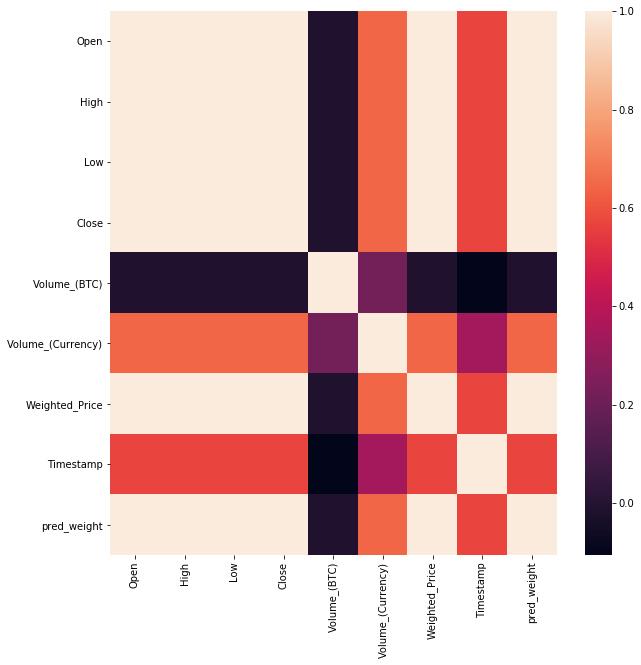

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

## 3.7 Time Series Graph

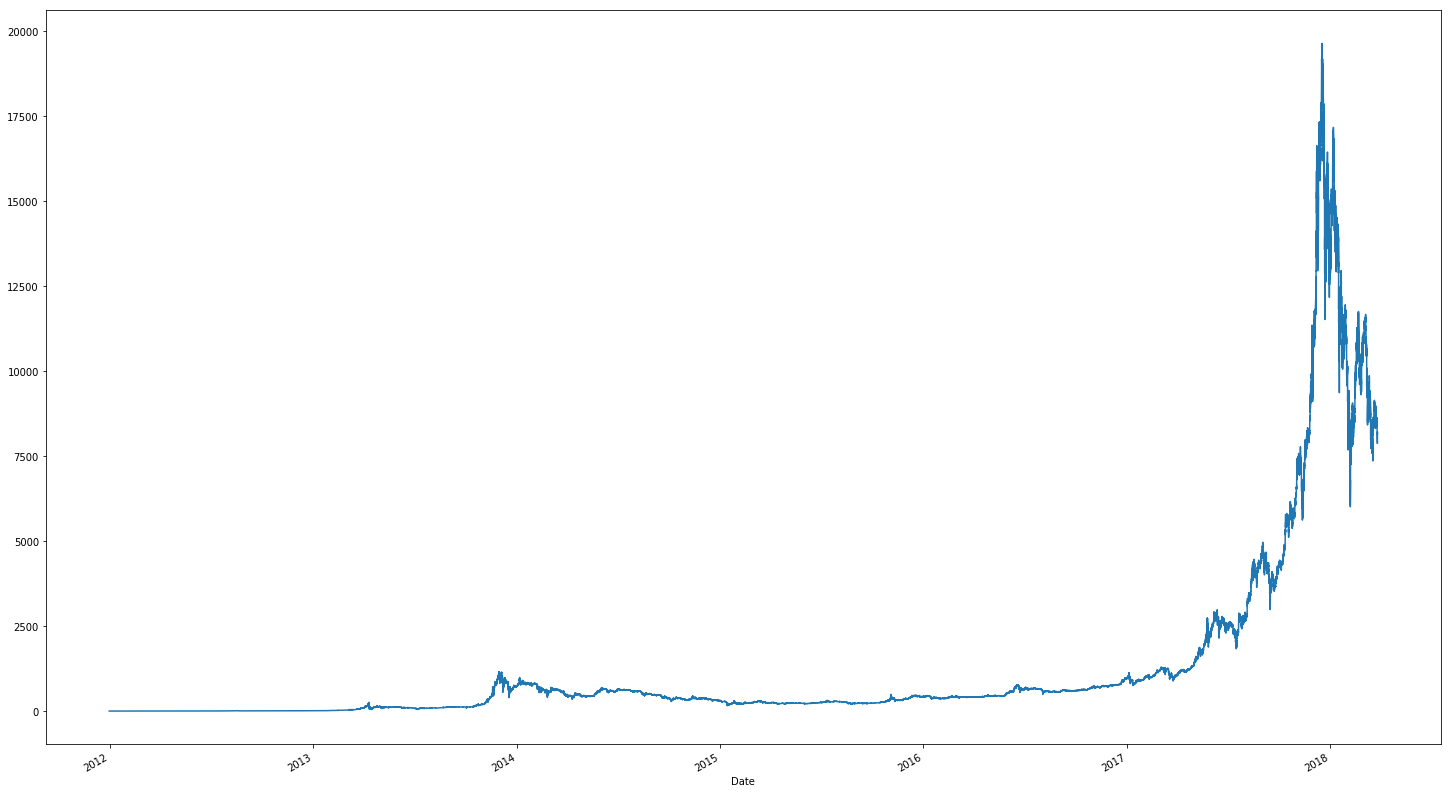

In [53]:
df['Weighted_Price'].plot(figsize = (25,15))

# Observations:
* From the end of 2017, there has been a rapid rise in value of Bitcoin.
* December 2017 showed the highest value of bitcoin.
* The period between 2012 to mid 2016 shows no significant fluctuations has been observed.

In [47]:
df['Close'].describe()

count    3.273377e+06
mean     1.282248e+03
std      2.812042e+03
min      1.500000e+00
25%      1.178500e+02
50%      3.960000e+02
75%      7.210500e+02
max      1.966575e+04
Name: Close, dtype: float64

# 4 Feature Engineering

## 4.1 Indicator Variable:

## 2013 Price Hike

![title](Images/2013_spike.png)

* Source: CNBC

## Price Hike from May to September 2017 (Crossed $ 5000 mark)

![title](Images/may_spike.png)

## Price Hike from mid - October to December 2017.

![title](Images/2017_spike.png)

* Source: Coindesk

In [3]:
df['Price_Hike'] = 0

In [41]:
def price_hike(df,date_from,date_to):
    #This function sets the value of Price_Hike to 1 in the given time frame
    
    idx_start =  df.index[df['Date'] == date_from]
    idx_end =  df.index[df['Date'] == date_to]
    for i in range(idx_start[0], idx_end[0] + 1):
            df['Price_Hike'][i] = 1
    return df 

In [ ]:
df_sample = price_hike(df, '2013-02-14 00:00:00', '2013-09-27 00:00:00')

In [ ]:
df_sample = price_hike(df, '2017-05-01 00:00:00', '2017-09-30 00:00:00')

In [ ]:
df_sample = price_hike(df, '2017-10-01 00:00:00', '2017-12-31 00:00:00')

## 4.2 Interaction Feature

In [5]:
# Creates a new feature which shows the difference in BTC value after closing
df['Diff_Value'] = df['Close']-df['Open']

In [12]:
#Creates a new feature 'Status' which indicates whether the BTC price dropped or gained after closing
#Increased value is indicated by 1 and decreased value is indicated by 0
def partition(x):
    if x>=0:
        return 1
    return 0

df['Status']=df['Diff_Value'].map(partition)

In [14]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight,Date,Price_Hike,Diff_Value,Status
327333,8190.726,8197.484,8187.408,8192.613,21.636469,1.772500e+05,8192.824829,1.522106e+09,8218.781100,2018-03-26 23:10:00,0,1.887,1
327334,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762,2018-03-26 23:20:00,0,-1.028,0
327335,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603,2018-03-26 23:30:00,0,-3.000,0
327336,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796,2018-03-26 23:40:00,0,-0.352,0
327337,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220,2018-03-26 23:50:00,0,-2.374,0


### Saving the final dataframe to disk

In [ ]:
df.to_csv('final_bitcoin.csv', index=None)

# 5. Machine Learning Models
## 5.1 Data Preparation

In [4]:
df = pd.read_csv("final_bitcoin.csv")

### 5.1.1 Train and Test Splits
Separate your dataframe into separate objects for the target variable (y) and the input features (X) and perform the train and test split

In [5]:
# Create separate object for target variable
y = df.pred_weight
# Create separate object for input features
X = df.drop(columns = ['pred_weight','Date','Timestamp'], axis=1)

In [6]:
# Split X and y into train and test sets: 80-20 (Time based splitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(261870, 10) (65468, 10) (261870,) (65468,)


## 5.2 Model 1 - Baseline Model
* In this model, for every test data point, we will simply predict the average of the train labels as the output.
* We will use this simple model to perform hypothesis testing for other complex models.

In [19]:
## Predict Train results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [20]:
## Predict Test results
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [21]:
print("Train Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Baseline Model:
*******************************
Root mean squared error:  251.98000475088818
R-squared:  0.0
Mean Absolute Error:  215.56026592


In [22]:
print("Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Results for Baseline Model:
*******************************
Root mean squared error:  6633.335576968769
R-squared:  -1.15897190758
Mean Absolute Error:  4860.09689154


## 5.3 Model 2 - Ridge Regression

In [27]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Ridge(), tuned_params, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [28]:
model.best_estimator_

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [30]:
## Predict Test results
y_pred = model.predict(X_test)

In [27]:
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  1.5666082834253139
R-squared:  0.999961346513
Mean Absolute Error:  0.562249698494


In [28]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  35.37561469080161
R-squared:  0.999938596794
Mean Absolute Error:  16.1488340837


## 5.3.1 Feature Importance

In [29]:
## Building the model again with the best hyperparameters
model = Ridge(alpha=100000)
model.fit(X_train, y_train)

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Close
Diff_Value
Weighted_Price
High
Low
Status
Open
Price_Hike
Volume_(BTC)
Volume_(Currency)


## 5.4 Model 4 - Random Forest Regression

In [7]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [8]:
model.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [10]:
## Predict Test results
y_pred = model.predict(X_test)

In [11]:
print("Train Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Random Forest Regression:
*******************************
Root mean squared error:  1.070533113843736
R-squared:  0.99998195038
Mean Absolute Error:  0.365299285444


In [13]:
print("Test Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Random Forest Regression:
*******************************
Root mean squared error:  6039.132889445278
R-squared:  -0.789502158913
Mean Absolute Error:  4042.70934561


## 5.4.1 Feature Importance

In [15]:
## Building the model again with the best hyperparameters
model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=4)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Close
Weighted_Price
High
Low
Open
Diff_Value
Volume_(BTC)
Volume_(Currency)
Status
Price_Hike


## 5.5 KNN Regression

In [27]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 1.


In [34]:
model = KNeighborsRegressor(n_neighbors = 1)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [35]:
y_train_pred = model.predict(X_train)

In [36]:
y_pred = model.predict(X_test)

In [31]:
print("Train Results for KNN Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for KNN Regression:
**a*****************************
Root mean squared error:  0.02027800953540406
R-squared:  0.999999993524
Mean Absolute Error:  0.00147003799877


In [32]:
print("Test Results for KNN Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for KNN Regression:
*******************************
Root mean squared error:  6187.855846874611
R-squared:  -0.878725930895
Mean Absolute Error:  4171.76141427


## 5.6 Lasso Regression

In [8]:
tuned_params = {'alpha' : [0.001,0.01,0.1,1,10,100,1000]}
model = GridSearchCV(linear_model.Lasso(), tuned_params, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [9]:
model.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
y_train_pred = model.predict(X_train)

In [12]:
y_pred = clf.predict(X_test)

In [13]:
print("Train Results for Lasso Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Lasso Regression:
**a*****************************
Root mean squared error:  1.5670392266222117
R-squared:  0.999961325245
Mean Absolute Error:  0.560471923249


In [14]:
print("Test Results for Lasso Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Lasso Regression:
*******************************
Root mean squared error:  35.023817077111254
R-squared:  0.999939811987
Mean Absolute Error:  16.0315185253


## 5.7 Decision Tree Regression

In [19]:
reg = DecisionTreeRegressor(random_state = 123)
reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best')

In [20]:
cross_val_score(reg, X_train, y_train, cv = 5)

array([-2.19873586,  0.94724539,  0.99945601,  0.99907172,  0.99972992])

In [21]:
y_pred = reg.predict(X_test)

In [22]:
y_train_pred = reg.predict(X_train)

In [23]:
print("Train Results for Decision Tree Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Decision Tree Regression:
**a*****************************
Root mean squared error:  0.012919265241842958
R-squared:  0.999999997371
Mean Absolute Error:  0.00136662735771


In [24]:
print("Test Results for Decision Tree Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Decision Tree Regression:
*******************************
Root mean squared error:  6038.101359059112
R-squared:  -0.788890889634
Mean Absolute Error:  4041.63640218


## 6. Saving the best model to disk

In [26]:
win_model = linear_model.Lasso(alpha = 0.1)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'lasso_btc.pkl') 

['lasso_btc.pkl']

## Observations:

![title](Images/Table.png)

* Except Rigde and Lasso Regression Models, others tend to overfit.
* Ridge and Lasso Regression models gives almost same results.